# Image Segmentation using U-Net  
This notebook implements an image segmentation pipeline using a U-Net architecture trained on the Oxford-IIIT Pet Dataset.


In [1]:
# Importing important libraries
import tensorflow as tf
from tensorflow.keras import layers, models
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import gradio as gr
import tensorflow.keras.backend as K
import gradio as gr
import warnings
warnings.filterwarnings("ignore")


/Users/mohammedrabei/miniconda3/envs/ml/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Loading and Preparing the Dataset
We load the Oxford-IIIT Pet dataset and preprocess images and masks by resizing them and normalizing the image pixel values.


In [2]:
dataset, info = tfds.load(
    'oxford_iiit_pet:4.0.0', 
    with_info=True, 
    download=True, 
    try_gcs=True, 
    as_supervised=False
)

train_dataset = dataset['train']
test_dataset = dataset['test']


## Preprocessing Function  
- Resizes images  
- Normalizes pixel values  
- Adjusts segmentation masks to class indices  


In [3]:
IMG_SIZE = 128

In [4]:


def preprocess(data):
    images, masks = [], []

    for sample in data:
        image = tf.image.resize(sample["image"], (IMG_SIZE, IMG_SIZE)) / 255.0
        mask = tf.image.resize(sample["segmentation_mask"], (IMG_SIZE, IMG_SIZE), method="nearest")
        mask = tf.cast(mask, tf.int32) - 1
        images.append(image)
        masks.append(mask)

    return np.array(images), np.array(masks)

train_dataset_images, train_dataset_masks = preprocess(train_dataset)
test_dataset_images, test_dataset_masks = preprocess(test_dataset)

train_dataset_masks = tf.one_hot(train_dataset_masks.squeeze(), 3)
test_dataset_masks  = tf.one_hot(test_dataset_masks.squeeze(), 3)


# Building the U-Net Model
The U-Net consists of an encoder-decoder architecture with skip connections.

In [5]:
def Unet(input_shape):
    Input_layer = layers.Input(shape=input_shape)

    # Encoder
    c1 = layers.Conv2D(4, 3, activation='relu', padding='same')(Input_layer)
    c1 = layers.Conv2D(4, 3, activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D(2)(c1)

    c2 = layers.Conv2D(8, 3, activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(8, 3, activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D(2)(c2)

    c3 = layers.Conv2D(16, 3, activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(16, 3, activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D(2)(c3)

    c4 = layers.Conv2D(32, 3, activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(32, 3, activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D(2)(c4)

    # Bottleneck
    a5 = layers.Conv2D(64, 3, activation='relu', padding='same')(p4)
    a5 = layers.Conv2D(64, 3, activation='relu', padding='same')(a5)

    # Decoder
    d1 = layers.Conv2DTranspose(128, 2, strides=2, padding='same', activation='relu')(a5)
    d1 = layers.concatenate([d1, c4])
    d1 = layers.Conv2D(32, 3, activation='relu', padding='same')(d1)
    d1 = layers.Conv2D(32, 3, activation='relu', padding='same')(d1)

    d2 = layers.Conv2DTranspose(64, 2, strides=2, padding='same', activation='relu')(d1)
    d2 = layers.concatenate([d2, c3])
    d2 = layers.Conv2D(16, 3, activation='relu', padding='same')(d2)
    d2 = layers.Conv2D(16, 3, activation='relu', padding='same')(d2)

    d3 = layers.Conv2DTranspose(32, 2, strides=2, padding='same', activation='relu')(d2)
    d3 = layers.concatenate([d3, c2])
    d3 = layers.Conv2D(8, 3, activation='relu', padding='same')(d3)
    d3 = layers.Conv2D(8, 3, activation='relu', padding='same')(d3)

    d4 = layers.Conv2DTranspose(16, 2, strides=2, padding='same', activation='relu')(d3)
    d4 = layers.concatenate([d4, c1])
    d4 = layers.Conv2D(4, 3, activation='relu', padding='same')(d4)
    d4 = layers.Conv2D(4, 3, activation='relu', padding='same')(d4)

    output_layer = layers.Conv2D(3, 1, activation="softmax")(d4)

    return models.Model(Input_layer, output_layer)

model = Unet((IMG_SIZE, IMG_SIZE, 3))


# Loss Function  
A combination of Dice Loss and Categorical Crossentropy.


In [6]:
def combined_loss(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)

    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    dice_loss = 1 - dice

    cce = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
    return dice_loss + K.mean(cce)


In [ ]:
model.compile(
    optimizer="adam",
    loss=combined_loss,
    metrics=["accuracy"]
)


# Training the Model


In [ ]:
history = model.fit(
    train_dataset_images,
    train_dataset_masks,
    batch_size=64,
    epochs=30,
    validation_data=(test_dataset_images, test_dataset_masks),
)


# Plot Training Curves


In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Loss")

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title("Accuracy")

plt.show()


# Saving and Loading the Model


In [ ]:
model.save("pet_segmentation_model.keras")

In [7]:
model = tf.keras.models.load_model(
    "pet_segmentation_model.keras",
    custom_objects={'combined_loss': combined_loss}
)

# Prediction Function  
Generates segmentation mask and overlays it on the input image.


In [8]:
def predict_image(image):

    h, w, _ = image.shape
    image_tensor = image

    if image.max() > 1.0:
        image = image / 255.0
        image_tensor = tf.convert_to_tensor(image, dtype=tf.float32)

    image_tensor = tf.image.resize(image_tensor, (IMG_SIZE, IMG_SIZE))
    image_tensor = tf.expand_dims(image_tensor, axis=0)

    mask = model.predict(image_tensor, verbose=0)
    mask = tf.argmax(mask, axis=-1)
    mask = tf.squeeze(mask, axis=0).numpy().astype(np.uint8)

    img_resized = np.array(tf.image.resize(tf.squeeze(image_tensor, axis=0), (IMG_SIZE, IMG_SIZE)))

    overlay = np.zeros_like(img_resized)
    for i in range(IMG_SIZE):
        for j in range(IMG_SIZE):
            if mask[i][j] == 1:
                overlay[i][j] = img_resized[i][j]
            else:
                overlay[i][j] = 1 - img_resized[i][j]

    overlay = tf.image.resize(overlay, (h, w)).numpy()
    return overlay


# Testing on a Sample


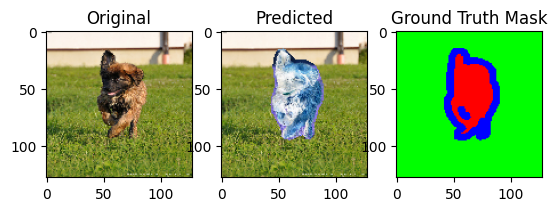

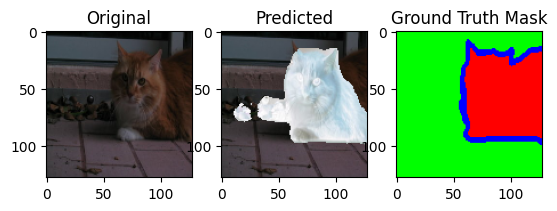

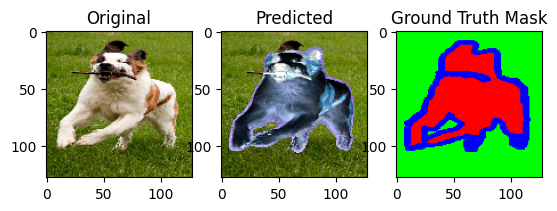

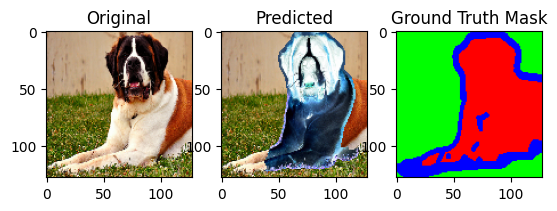

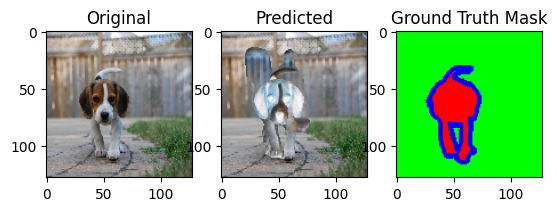

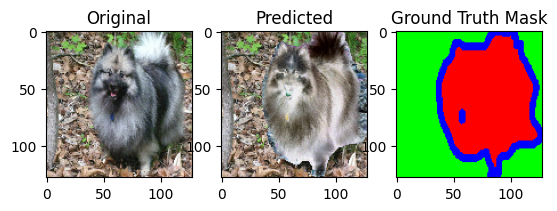

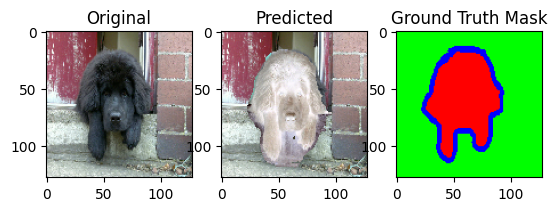

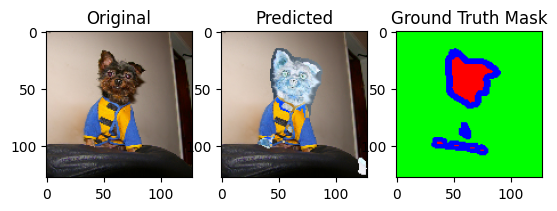

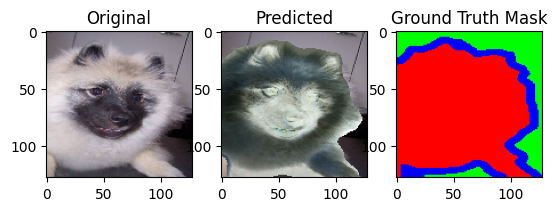

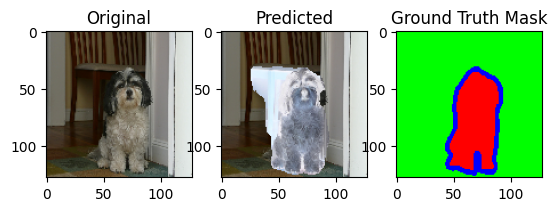

In [11]:
for i in range(10):
    img = predict_image(test_dataset_images[i])
    plt.subplot(1, 3, 1)
    plt.title("Original")
    plt.imshow(test_dataset_images[i])

    plt.subplot(1, 3, 2)
    plt.title("Predicted")
    plt.imshow(img)

    plt.subplot(1, 3, 3)
    plt.title("Ground Truth Mask")
    plt.imshow(test_dataset_masks[i])
    plt.show()


In [10]:
Infer = gr.Interface(
    fn=predict_image,
    inputs=gr.Image(type="numpy"),
    outputs=gr.Image(type="numpy"),

    description="Enter or drag your image here"
)

Infer.launch()


* Running on local URL:  http://127.0.0.1:7861
* To create a public link, set `share=True` in `launch()`.
